In [8]:
fs = 32e9  # 32 GHz sampling rate
fs_num = 32  # 32 GHz sampling rate in numerical form
up_fs = 1024e9  # 1024 GHz upsampled rate
up_fs_num = 1024  # 1024 GHz upsampled rate in numerical form

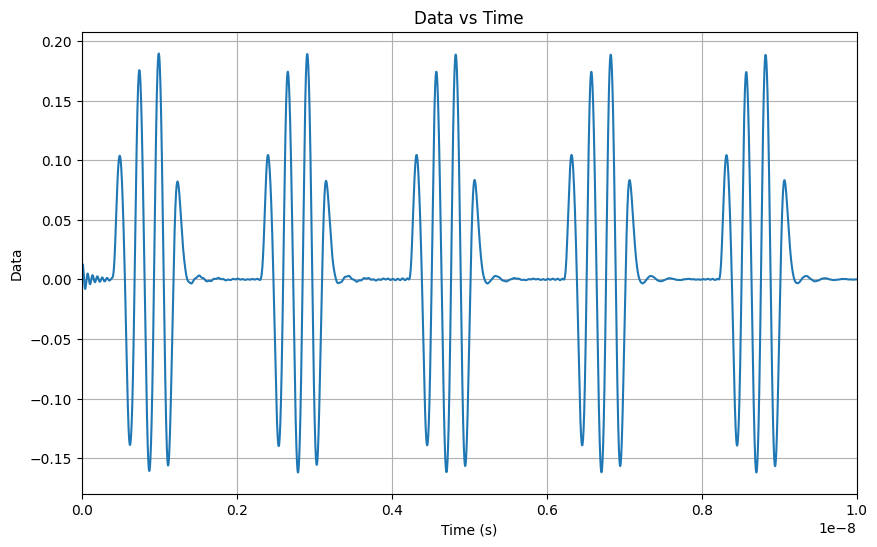

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming up_fs_num is defined somewhere earlier in the code
# up_fs_num = ...

# Read CSV file from the csv folder in the current directory
csv_path = f'../csv/phase_noise_ppm{up_fs_num}.csv'
df = pd.read_csv(csv_path)

# Plot Data column vs Time
plt.figure(figsize=(10, 6))
plt.plot(df['time'], df['data'])
plt.xlabel('Time (s)')
plt.ylabel('Data')
plt.title('Data vs Time')
plt.grid(True)
plt.xlim(0, 1e-8)
plt.show()

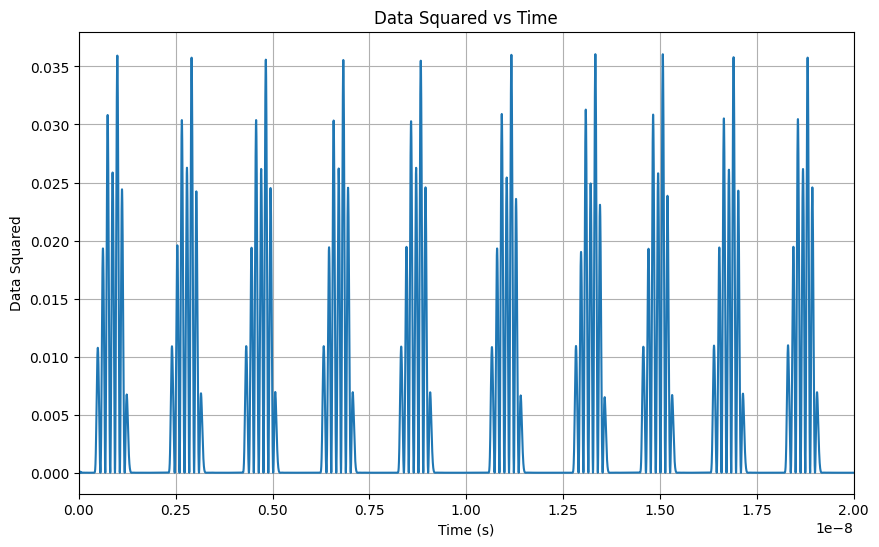

In [10]:
# Calculate the square of the data
df['Data_Squared'] = df['data'] ** 2
plt.figure(figsize=(10, 6))
plt.plot(df['time'], df['Data_Squared'])
plt.xlabel('Time (s)')
plt.ylabel('Data Squared')
plt.title('Data Squared vs Time')
plt.grid(True)
plt.xlim(0, 2e-8)
plt.show()

C:\Users\IWMAI\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


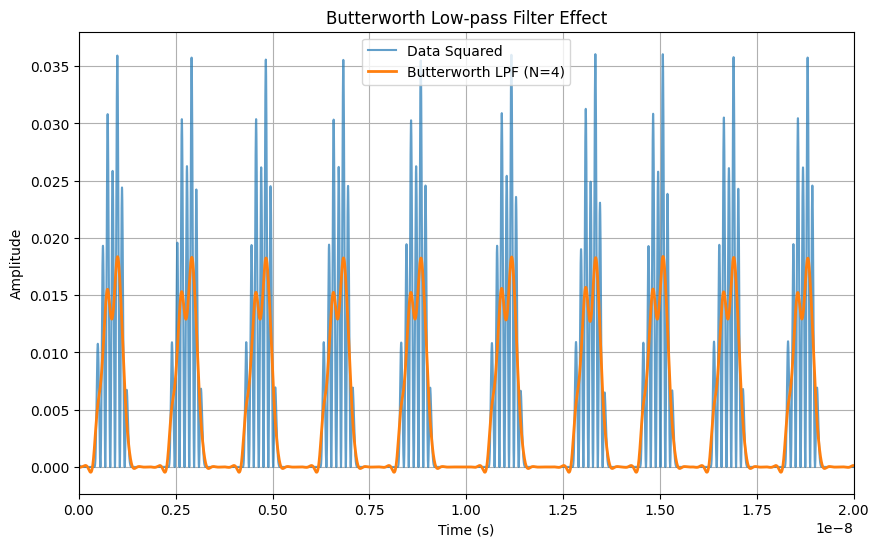

In [11]:
from scipy.signal import butter, filtfilt

# Butterworth low-pass filter parameters
native_sampling_rate = up_fs  # Use the upsampled frequency
cutoff = 4e9  # 4 GHz cutoff frequency
N = 4  # Filter order
nyq = native_sampling_rate / 2
cutoff_norm = cutoff / nyq

# Design Butterworth filter
b, a = butter(N, cutoff_norm, btype='low')

# Apply zero-phase filtering
df['Data_MA'] = filtfilt(b, a, df['Data_Squared'])

plt.figure(figsize=(10, 6))
plt.plot(df['time'], df['Data_Squared'], label='Data Squared', alpha=0.7)
plt.plot(df['time'], df['Data_MA'], label=f'Butterworth LPF (N={N})', linewidth=2)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Butterworth Low-pass Filter Effect')
plt.legend()
plt.xlim(0, 2e-8)
plt.grid(True)
plt.show()

Found 2499 pulse midpoints
Midpoint times: [8.47656250e-10 2.76367188e-09 4.67968750e-09 ... 4.99293262e-06
 4.99476172e-06 4.99667578e-06]


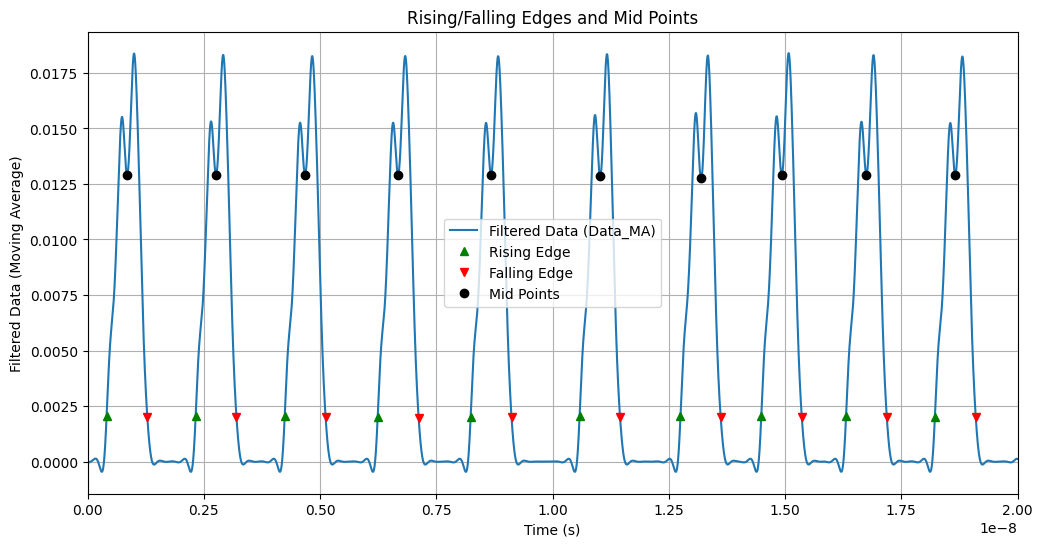

In [12]:
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt

# Set threshold
threshold = 0.002
native_sampling_rate = up_fs  # Use the upsampled frequency
symbol_rate = 500e6  # 500 MHz

# Get data
filtered_data = df["Data_MA"].values

# Calculate rising edge and falling edge
above = filtered_data > threshold
rising_edges = np.where(np.diff(above.astype(int)) == 1)[0] + 1  # Rising edges
falling_edges = np.where(np.diff(above.astype(int)) == -1)[0] + 1  # Falling edges

# Ensure each rising edge is followed by a falling edge
if falling_edges.size > 0 and rising_edges.size > 0:
    if falling_edges[0] < rising_edges[0]:
        falling_edges = falling_edges[1:]
    if rising_edges.shape[0] > falling_edges.shape[0]:
        rising_edges = rising_edges[:-1]

    # Calculate midpoint of each rising/falling pair
    mid_indices = ((rising_edges + falling_edges) / 2).astype(int)
    mid_times = df.loc[mid_indices, 'time'].values

    print(f"Found {len(mid_times)} pulse midpoints")
    print(f"Midpoint times: {mid_times}")
else:
    mid_indices = np.array([])
    mid_times = np.array([])
    print("No valid rising/falling edge pairs detected")

# Visualization
plt.figure(figsize=(12, 6))
plt.plot(df['time'], df['Data_MA'], label='Filtered Data (Data_MA)')
if rising_edges.size > 0:
    plt.plot(df.loc[rising_edges, 'time'], filtered_data[rising_edges], 'g^', label='Rising Edge')
if falling_edges.size > 0:
    plt.plot(df.loc[falling_edges, 'time'], filtered_data[falling_edges], 'rv', label='Falling Edge')
if mid_indices.size > 0:
    plt.plot(df.loc[mid_indices, 'time'], filtered_data[mid_indices], 'ko', label='Mid Points')
plt.xlabel('Time (s)')
plt.ylabel('Filtered Data (Moving Average)')
plt.title('Rising/Falling Edges and Mid Points')
plt.grid(True)
plt.legend()
plt.xlim(0, 2e-8)
plt.show()


Mid Point Analysis Results:
Number of mid points found: 2499
Mid indices: [868, 2830, 4792, 6840, 8887, 11281, 13500, 15283, 17152, 19110, 21156, 23553, 25428, 27740, 29530, 31493, 33458, 35860, 38086, 40223, 42272, 43973, 45846, 48155, 50027, 51984, 53940, 56332, 58203, 60509, 62642, 64429, 66303, 68615, 70841, 72978, 74680, 76904, 78691, 80999, 82784, 84742, 87048, 89267, 91398, 93445, 95493, 97193, 99418, 101208, 103171, 105136, 107187, 109587, 111811, 113945, 115643, 117514, 119472, 121866, 123737, 125695, 128003, 129876, 131836, 134148, 136373, 138162, 140388, 142527, 144316, 146541, 148329, 150639, 152774, 154558, 156776, 158907, 161037, 163080, 164777, 166996, 169132, 170919, 172794, 174758, 177160, 179388, 181178, 183403, 185192, 187153, 189462, 191335, 193642, 195774, 197905, 199602, 201822, 203956, 206091, 207791, 209666, 211979, 214205, 215994, 217869, 220179, 222053, 224360, 226144, 228449, 230234, 232540, 234676, 236811, 238861, 240912, 242964, 245015, 246717, 248592, 2505

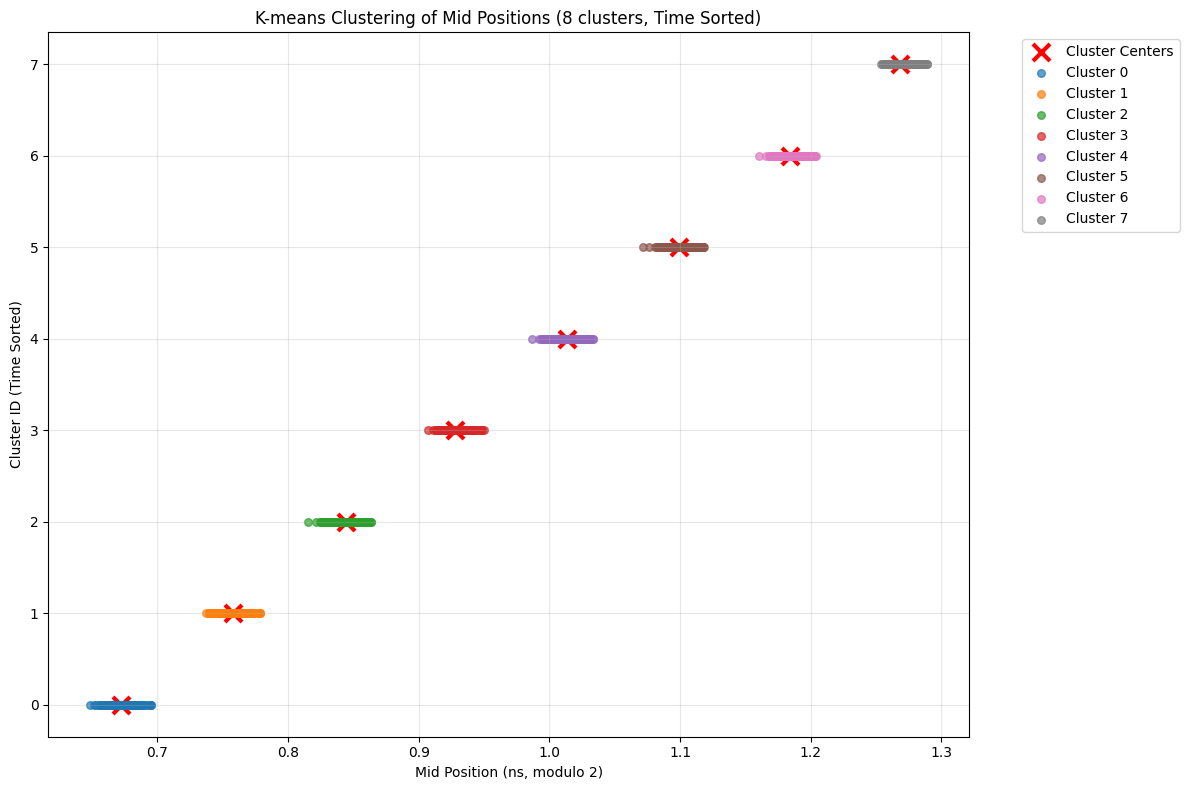

In [13]:
# Get list of all mid positions and use K-means clustering
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Extract mid positions from the previous analysis
if 'mid_indices' in locals() and 'mid_times' in locals():
    # List of mid indices in the dataframe
    mid_indices_list = mid_indices.tolist()
    
    # List of mid time positions
    mid_positions = mid_times.tolist()
    
    print("Mid Point Analysis Results:")
    print(f"Number of mid points found: {len(mid_positions)}")
    print(f"Mid indices: {mid_indices_list}")
    print(f"Mid time positions (seconds): {mid_positions}")
    
    # Convert to more readable format (nanoseconds)
    mid_positions_ns = [pos * 1e9 for pos in mid_positions]
    print(f"Mid time positions (nanoseconds): {mid_positions_ns}")
    
    # Calculate relative positions from the first mid point
    if len(mid_positions) > 1:
        relative_positions = [(pos - mid_positions[0]) * 1e9 for pos in mid_positions]
        print(f"Relative positions from first mid point (ns): {relative_positions}")
        
        # Calculate intervals between consecutive mid points
        intervals_ns = [pos * 1e9 for pos in np.diff(mid_positions)]
        print(f"Intervals between consecutive mid points (ns): {intervals_ns}")
        
    # Use K-means clustering on mid positions (modulo 2ns for periodic analysis)
    if len(mid_positions_ns) > 8:  # Need at least 8 points for 8 clusters
        mid_positions_mod = np.array([pos % 2 for pos in mid_positions_ns]).reshape(-1, 1)
        
        # Apply K-means with 8 clusters
        kmeans = KMeans(n_clusters=8, random_state=42)
        cluster_labels_original = kmeans.fit_predict(mid_positions_mod)
        cluster_centers = kmeans.cluster_centers_.flatten()
        
        # Create mapping to sort clusters by time position
        center_time_pairs = [(i, center) for i, center in enumerate(cluster_centers)]
        center_time_pairs.sort(key=lambda x: x[1])  # Sort by time position
        
        # Create mapping from original cluster ID to time-sorted cluster ID
        old_to_new_mapping = {}
        for new_id, (old_id, _) in enumerate(center_time_pairs):
            old_to_new_mapping[old_id] = new_id
        
        # Apply the mapping to cluster labels
        cluster_labels = np.array([old_to_new_mapping[label] for label in cluster_labels_original])
        
        # Sort cluster centers by time position
        sorted_centers = [pair[1] for pair in center_time_pairs]
        
        print("\n=== K-means Clustering Results (8 clusters) - Time Sorted ===")
        for i, center in enumerate(sorted_centers):
            cluster_size = np.sum(cluster_labels == i)
            print(f"Cluster {i}: Time = {center:.4f} ns (modulo 2), Points = {cluster_size}")
        
        # Convert cluster centers to picoseconds and display as list
        # cluster_centers_ps = [int(round(center * 1000)) for center in sorted_centers]
        # print(f"\nCluster centers in picoseconds (time sorted): {cluster_centers_ps}")
        print(f"\nCluster centers in picoseconds (time sorted): [", end="")
        for i in range(len(sorted_centers)):
            print(f"{sorted_centers[i] * 1000:.2f}", end=" " if i < len(sorted_centers) - 1 else "")
        print("]")

        # Print a nanosecond list
        print(f"\nCluster centers in nanoseconds (time sorted): [", end="")
        for i in range(len(sorted_centers)):
            print(f"{sorted_centers[i]:.8f}", end=" " if i < len(sorted_centers) - 1 else "")
        print("]")

        # Visualize clustering results
        plt.figure(figsize=(12, 8))
        colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f']

        # Plot cluster centers (now time-sorted)
        plt.scatter(sorted_centers, range(8), color='red', marker='x', s=150, 
                   linewidths=3, label='Cluster Centers')
        
        # Plot cluster points
        for i in range(8):
            cluster_points = mid_positions_mod[cluster_labels == i]
            plt.scatter(cluster_points, np.ones(len(cluster_points)) * i, 
                       color=colors[i], alpha=0.7, s=30, label=f'Cluster {i}')
        
        plt.xlabel('Mid Position (ns, modulo 2)')
        plt.ylabel('Cluster ID (Time Sorted)')
        plt.title('K-means Clustering of Mid Positions (8 clusters, Time Sorted)')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
        
    else:
        print(f"Not enough mid points for K-means clustering (found {len(mid_positions_ns)}, need > 8)")
        
else:
    print("Please run the mid point detection cell first to generate mid point data.")

=== Symbol Classification Results ===
Total classified symbols: 2499
Symbol period: 2.0 ns

First 20 symbol classification results:
    index  pulse_position  data
0       0        0.847656     2
1       1        0.763672     1
2       2        0.679688     0
3       3        0.679688     0
4       4        0.678711     0
5       5        1.016602     4
6       6        1.183594     6
7       7        0.924805     3
8       8        0.750000     1
9       9        0.662109     0
10     10        0.660156     0
11     11        1.000977     4
12     12        0.832031     2
13     13        1.089844     5
14     14        0.837891     2
15     15        0.754883     1
16     16        0.673828     0
17     17        1.019531     4
18     18        1.193359     6
19     19        1.280273     7

Statistics for each symbol type:
Symbol type 0: 296 occurrences
Symbol type 1: 316 occurrences
Symbol type 2: 315 occurrences
Symbol type 3: 315 occurrences
Symbol type 4: 315 occurrences
Symbol 

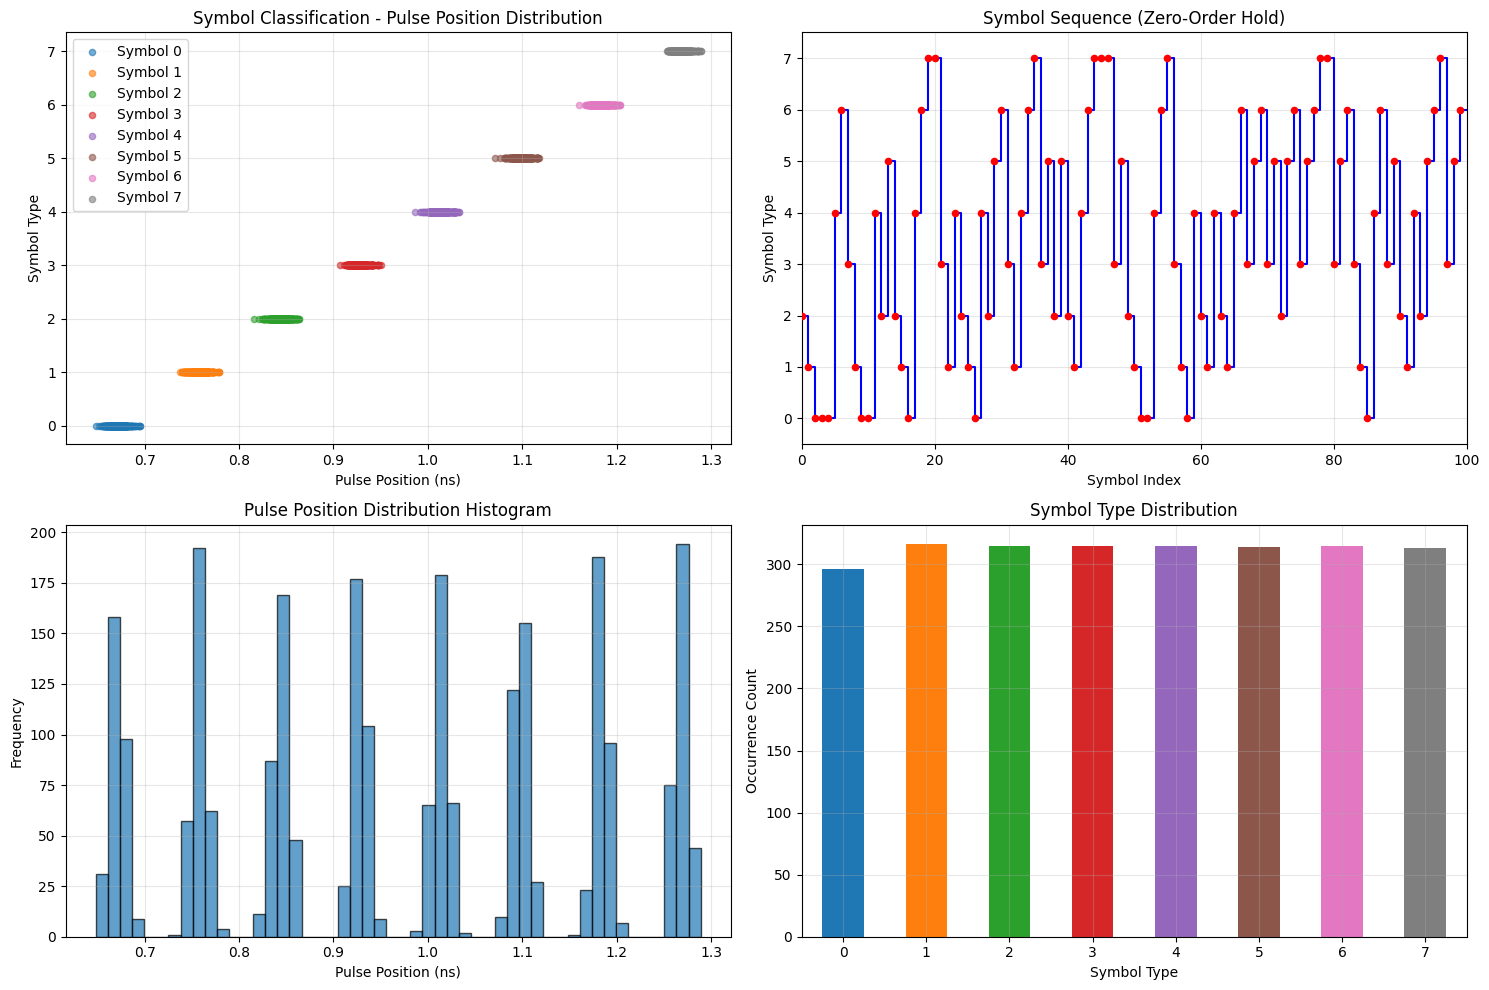


Symbol classification DataFrame created successfully, variable name: 'symbol_df'
DataFrame shape: (2499, 3)
Column names: ['index', 'pulse_position', 'data']

DataFrame saved to: ../csv/ppm_decode_1024.csv


In [14]:
# Symbol Classification and DataFrame Creation
# Symbol rate: 500MHz, each symbol period is 2ns, aligned to [0, 2, 4, 6...] ns

symbol_rate = 500e6  # 500 MHz
symbol_period_ns = 1 / symbol_rate * 1e9  # 2 ns

# Get clustering results from previous analysis
if 'cluster_labels' in locals() and 'mid_positions_ns' in locals():
    # Create symbol classification DataFrame
    symbol_data = []
    
    # Classify each detected pulse midpoint
    for i, (mid_pos_ns, cluster_id) in enumerate(zip(mid_positions_ns, cluster_labels)):
        # Calculate corresponding symbol time slot (with 2ns period)
        symbol_slot = int(round(mid_pos_ns / symbol_period_ns))
        
        # Calculate relative position within 2ns period
        pulse_position = mid_pos_ns % symbol_period_ns
        
        # Use cluster ID as data value (0-7 for 8 different symbols)
        data_value = cluster_id
        
        symbol_data.append({
            'index': i,
            'pulse_position': pulse_position,
            'data': data_value
        })
    
    # Create new DataFrame
    symbol_df = pd.DataFrame(symbol_data)
    
    print("=== Symbol Classification Results ===")
    print(f"Total classified symbols: {len(symbol_df)}")
    print(f"Symbol period: {symbol_period_ns:.1f} ns")
    print("\nFirst 20 symbol classification results:")
    print(symbol_df.head(20))
    
    print("\nStatistics for each symbol type:")
    data_counts = symbol_df['data'].value_counts().sort_index()
    for data_val, count in data_counts.items():
        print(f"Symbol type {data_val}: {count} occurrences")
    
    print("\nPulse position statistics:")
    print(f"Pulse position range: {symbol_df['pulse_position'].min():.4f} - {symbol_df['pulse_position'].max():.4f} ns")
    print(f"Pulse position mean: {symbol_df['pulse_position'].mean():.4f} ns")
    print(f"Pulse position std: {symbol_df['pulse_position'].std():.4f} ns")
    
    # Plot symbol classification visualization
    plt.figure(figsize=(15, 10))
    
    # Subplot 1: Pulse position distribution
    plt.subplot(2, 2, 1)
    # Define 8 different colors
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f']
    for i in range(8):
        mask = symbol_df['data'] == i
        if mask.sum() > 0:
            plt.scatter(symbol_df.loc[mask, 'pulse_position'], 
                       symbol_df.loc[mask, 'data'], 
                       color=colors[i], alpha=0.6, s=20, label=f'Symbol {i}')
    
    plt.xlabel('Pulse Position (ns)')
    plt.ylabel('Symbol Type')
    plt.title('Symbol Classification - Pulse Position Distribution')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Subplot 2: Time series (zero-order hold style)
    plt.subplot(2, 2, 2)
    
    # Create zero-order hold plot
    x_vals = []
    y_vals = []
    
    # Show first 100 symbols for better visibility
    plot_length = min(100, len(symbol_df))
    
    for i in range(plot_length):
        # Add two points for each symbol to create step effect
        x_vals.extend([i, i + 1])
        y_vals.extend([symbol_df.iloc[i]['data'], symbol_df.iloc[i]['data']])
    
    plt.plot(x_vals, y_vals, linewidth=1.5, color='blue')
    plt.scatter(symbol_df['index'][:plot_length], symbol_df['data'][:plot_length], 
                c='red', s=20, zorder=5)
    
    plt.xlabel('Symbol Index')
    plt.ylabel('Symbol Type')
    plt.title('Symbol Sequence (Zero-Order Hold)')
    plt.grid(True, alpha=0.3)
    plt.xlim(0, plot_length)
    plt.ylim(-0.5, 7.5)
    
    # Subplot 3: Pulse position histogram
    plt.subplot(2, 2, 3)
    plt.hist(symbol_df['pulse_position'], bins=50, alpha=0.7, edgecolor='black')
    plt.xlabel('Pulse Position (ns)')
    plt.ylabel('Frequency')
    plt.title('Pulse Position Distribution Histogram')
    plt.grid(True, alpha=0.3)
    
    # Subplot 4: Symbol type distribution
    plt.subplot(2, 2, 4)
    data_counts.plot(kind='bar', color=colors[:len(data_counts)])
    plt.xlabel('Symbol Type')
    plt.ylabel('Occurrence Count')
    plt.title('Symbol Type Distribution')
    plt.xticks(rotation=0)
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Save result DataFrame
    print(f"\nSymbol classification DataFrame created successfully, variable name: 'symbol_df'")
    print(f"DataFrame shape: {symbol_df.shape}")
    print(f"Column names: {list(symbol_df.columns)}")
    
    # Save DataFrame to CSV file
    output_csv_path = f'../csv/ppm_decode_{up_fs_num}.csv'
    symbol_df.to_csv(output_csv_path, index=False)
    print(f"\nDataFrame saved to: {output_csv_path}")
    
else:
    print("Error: Please run the previous clustering analysis cell first to generate clustering results")
